Evaluating Lyapunov fixed env
Evaluating Lyapunov Dynamic env


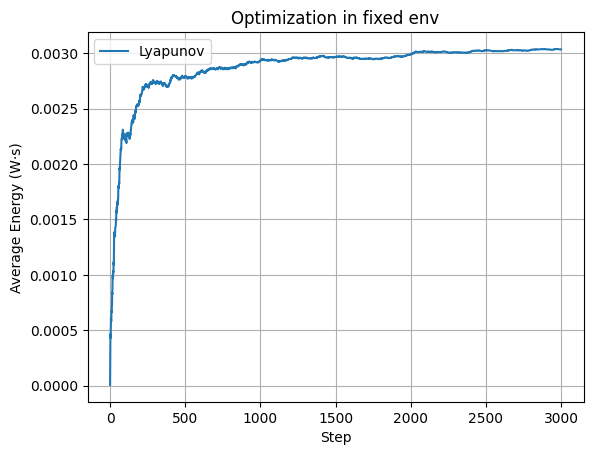

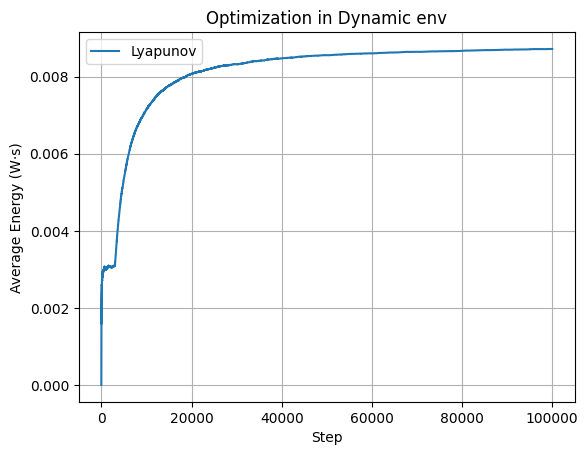


Execution Time Summary:
              Method   Time (s)
  Lyapunov Fixed Env   3.150902
Lyapunov Dynamic Env 104.895188


In [34]:
# Comparison of Lyapunov, PG-RL, and Lifelong PG-RL with GPU Support
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Lasso
from sklearn.preprocessing import normalize
import time
import pandas as pd

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------- Environment ----------------------------
class WSNEnvFixed:
    def __init__(self):
        self.NumberTxs = 2
        self.Bandwidth = 5e6
        self.NoisePowerWatt = 10**(-120 / 10) / 1000
        self.Tx0MaxPowerWatt = 0.03
        self.BatteryCapacityJoul = 0.1
        self.ArrivalDataRate = 5
        self.ComChannScale = 1.0
        self.EHChannScale = 1.0
        self.EHPowerConversionEffi = 0.1
        self.reset()

    def reset(self):
        self.queues = np.zeros(self.NumberTxs)
        self.batteries = np.zeros(self.NumberTxs - 1)
        self.CommChannGain = np.random.rayleigh(scale=self.ComChannScale, size=self.NumberTxs)
        self.EHChannGain = np.random.rayleigh(scale=self.EHChannScale, size=1)
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.queues, self.batteries, self.CommChannGain, self.EHChannGain])

    def step(self, action):
        Tx0Power, Tx0CommTime, Tx1CommTime, EHTime = action
        Arrivals = np.random.poisson(self.ArrivalDataRate, self.NumberTxs)
        Tx0TransmitData = self.Bandwidth * np.log2(1 + (Tx0Power * self.CommChannGain[0]) / self.NoisePowerWatt) * Tx0CommTime
        Tx0TransmitData = float(min(Tx0TransmitData, self.queues[0]))
        Tx1Power = (self.batteries / EHTime).item()
        Tx1Rate = self.Bandwidth * np.log2(1 + (Tx1Power * self.CommChannGain[1]) / self.NoisePowerWatt)
        Tx1TransmitData = float(min(Tx1Rate * Tx1CommTime, self.queues[1]))
        HarvestedPow = self.EHPowerConversionEffi * (self.Tx0MaxPowerWatt - Tx0Power) * self.EHChannGain
        self.queues = np.maximum(self.queues - np.array([Tx0TransmitData, Tx1TransmitData]), 0) + Arrivals
        self.batteries = np.maximum(self.batteries - (Tx1Power * Tx1CommTime), 0) + (HarvestedPow * EHTime)
        self.CommChannGain = np.random.rayleigh(scale=self.ComChannScale, size=self.NumberTxs)
        self.EHChannGain = np.random.rayleigh(scale=self.EHChannScale, size=1)
        energy = (Tx0Power * Tx0CommTime) + (Tx1Power * Tx1CommTime)
        reward = -energy
        return self._get_state(), reward, False, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime

class WSNEnv(WSNEnvFixed):
    def update_conditions(self, step):
        if step == 3000:
            self.EHChannScale = 2.0
            self.EHPowerConversionEffi = 0.2

# ------------------------ Lyapunov Method --------------------------
def lyapunov_action(env, V=10):
    best_action, min_metric = None, float('inf')
    for _ in range(50):
        Tx0Power = np.random.uniform(0, env.Tx0MaxPowerWatt)
        time_split = np.random.dirichlet(np.ones(3))
        Tx0CommTime, EHTime, Tx1CommTime = time_split
        if EHTime <= 0 or Tx0CommTime + EHTime + Tx1CommTime > 1: continue
        q0, q1 = env.queues
        b1 = env.batteries[0]
        g0, g1 = env.CommChannGain
        N0 = env.NoisePowerWatt
        tx0_data = min(env.Bandwidth * np.log2(1 + (Tx0Power * g0 / N0)) * Tx0CommTime, q0)
        tx1_power = b1 / EHTime
        if tx1_power * Tx1CommTime > b1: continue
        tx1_data = min(env.Bandwidth * np.log2(1 + (tx1_power * g1 / N0)) * Tx1CommTime, q1)
        energy = Tx0Power * Tx0CommTime + tx1_power * Tx1CommTime
        drift = q0**2 + q1**2 - 2 * (q0 * tx0_data + q1 * tx1_data)
        metric = drift + V * energy
        if metric < min_metric:
            min_metric = metric
            best_action = [Tx0Power, Tx0CommTime, Tx1CommTime, EHTime]
    return best_action

def run_lyapunov_Dynamic(env, steps, V):
    energy_trace = []
    for step in range(steps):
        env.update_conditions(step)
        action = lyapunov_action(env, V)
        _, _, _, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime = env.step(action)
        energy = Tx0Power * Tx0CommTime + Tx1Power * Tx1CommTime
        energy_trace.append(energy)
    return energy_trace

def run_lyapunov(env, steps, V):
    energy_trace = []
    for step in range(steps):
        action = lyapunov_action(env, V)
        _, _, _, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime = env.step(action)
        energy = Tx0Power * Tx0CommTime + Tx1Power * Tx1CommTime
        energy_trace.append(energy)
    return energy_trace

if __name__ == "__main__":
    steps = 100000
    V = 10

    timings = []

    print("Evaluating Lyapunov fixed env")
    start_time = time.time()
    env_eval_lya = WSNEnvFixed()
    steps_fixed=3000
    energy_lya = run_lyapunov(env_eval_lya, steps_fixed, V)
    elapsed_time = time.time() - start_time
    timings.append({"Method": "Lyapunov Fixed Env", "Time (s)": elapsed_time})

    print("Evaluating Lyapunov Dynamic env")
    start_time = time.time()
    env_eval_lya = WSNEnv()
    energy_lya_dynamic = run_lyapunov_Dynamic(env_eval_lya, steps, V)
    elapsed_time = time.time() - start_time
    timings.append({"Method": "Lyapunov Dynamic Env", "Time (s)": elapsed_time})

    plt.figure()
    plt.plot(np.cumsum(energy_lya)/np.arange(1, steps_fixed+1), label="Lyapunov")
    plt.title("Optimization in fixed env")
    plt.xlabel("Step")
    plt.ylabel("Average Energy (W·s)")
    plt.legend()
    plt.grid(True)

    plt.figure()
    plt.plot(np.cumsum(energy_lya_dynamic)/np.arange(1, steps+1), label="Lyapunov")
    plt.title("Optimization in Dynamic env")
    plt.xlabel("Step")
    plt.ylabel("Average Energy (W·s)")
    plt.legend()
    plt.grid(True)

    plt.show()

    # Display timing table
    df_timings = pd.DataFrame(timings)
    print("\nExecution Time Summary:")
    print(df_timings.to_string(index=False))

